In [11]:
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# from app.APN.training.data_manager.dataloader import CardiacDataset,\
#      dataloader

# load prepared data
# from sklearn.model_selection import train_test_split

# IMPORT DATA DICTIONARIES

# define data dictionaries
with open('./app/APN/model/files/desc_data.json') as json_file:
    desc_data = json.load(json_file)
json_file.close()

with open('./app/APN/model/files/outcome_data.json') as json_file:
    outcome_data = json.load(json_file)
json_file.close()

with open('./app/APN/model/files/input_data.json') as json_file:
    input_data = json.load(json_file)
json_file.close()

print(len(desc_data), len(input_data), len(outcome_data))

# DEFINE COLNAME ARRAYS

outcome_colnames = [d["colname"] for d in outcome_data]
input_colnames = [d["colname"] for d in input_data]
desc_colnames = [d["colname"] for d in desc_data]


# import data and split into train and valid based on date of admission
path = "full_data.csv"
ev_path = "mimic_sub.csv"

data = pd.read_csv(path).dropna(subset=['DOA', 'DOP'])
ev = pd.read_csv(ev_path, index_col=False)

data.DOP = pd.to_datetime(data.DOA)
data = data.set_index("DOA").sort_index()

6 115 11


In [12]:
data.AGE

DOA
2001-04-07    63.0
2001-04-29    20.0
2001-05-23    72.0
2001-05-24    64.0
2001-05-25    64.0
              ... 
2019-12-30    38.0
2019-12-31    71.0
2019-12-31    63.0
2019-12-31    62.0
2019-12-31    53.0
Name: AGE, Length: 153932, dtype: float64

In [13]:
print(data.OpID.unique().shape)
print(data.PatID.unique().shape)

(153932,)
(151078,)


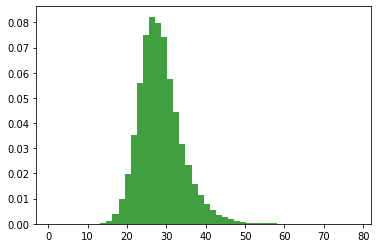

In [14]:
n, bins, patches = plt.hist([x if x < 80 else np.nan for x in data.BMI.values], 50, density=True, facecolor='g', alpha=0.75)

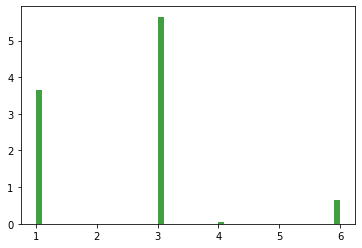

In [15]:
n, bins, patches = plt.hist(ev.Insur.values, 50, density=True, facecolor='g', alpha=0.75)

In [16]:
np.sum([1 if x > 0 else 0 for x in data.MI.values])

54023

In [30]:
## prep each feature
dd = {}
dp = {}
de = {}
ddo = {}
deo = {}
feature_dict = []
outcome_dict = []
## removed
# insurance

## helper function to make dummy variables
def binarize(x1, x2):
    if np.isnan(x1):
        return np.nan
    if x1 == -1:
        return -1
    if x1 == x2:
        return 1
    else:
        return 0     
    
# characteristics and comorbidities
## DEMOGRAPHIC
dd["AGE"] = [x for x in data.AGE.values]
dp["AGE"] = [x for x in data.AGE.values]
de["AGE"] = [x for x in ev.AGE.values]
feature_dict.append({
    "name": "Age (years)",
    "colname": "AGE",
    "type": "number",
    "values": [
        0,
        110
    ],
    "val_label": "continuous",
    "units": "years",
    "timing": 0,
    "class":"demographic"
})

# 1 is male, 2 is female
dd["Sex"] = [1 if x == 1 else 0 for x in data.Sex.values]
dp["Sex"] = [1 if x == 1 else 0 for x in data.Sex.values]
de["Sex"] = [1 if x == 1 else 0 for x in ev.Sex.values]
feature_dict.append({
    "name": "Sex",
    "colname": "Sex",
    "type": "binary",
    "values": [
        0,
        1
    ],
    "val_label": [
        "Female",
        "Male"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"demographic"
})


dd["BMI"] = [x if x < 60 else np.nan for x in data.BMI.values]
dp["BMI"] = [x if x < 60 else np.nan for x in data.BMI.values]
de["BMI"] = [x if x < 60 else np.nan for x in ev.BMI.values]
feature_dict.append({
    "name": "Body Mass Index",
    "colname": "BMI",
    "type": "number",
    "values": [
        -1,
        60
    ],
    "val_label": "continuous",
    "units": "NaN",
    "timing": 0,
    "class":"demographic"
})


dd["Race1"] = [x for x in data.Race1.values]
dp["Race1"] = [np.nan for x in data.Race1.values]
de["Race1"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Indigenous Status",
    "colname": "Race1",
    "type": "binary",
    "values": [
        0,
        1
    ],
    "val_label": [
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"demographic"
})

dd["Insur"] = [x if x < 7 else np.nan for x in data.Insur.values]
dp["Insur"] = [x if x < 7 else np.nan for x in data.Insur.values]
de["Insur"] = [x if x < 7 else np.nan for x in ev.Insur.values]
feature_dict.append({
    "name": "Insurance",
    "colname": "Insur",
    "type": "categorical",
    "values": [
        -1,
        1,
        2,
        3,
        4,
        5,
        6,
    ],
    "val_label": [
        "Unknown",
        "Private",
        "DVA",
        "Medicare",
        "Self Insured",
        "Overseas",
        "Other",
    ],
    "units": "NaN",
    "timing": 0,
    "class":"demographic"
})

## HISTORY

dd["POP"] = [x for x in data.POP.values]
dp["POP"] = [np.nan for x in data.POP.values]
de["POP"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Previous Cardiac Procedure",
    "colname": "POP",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["ARRT"] = [x for x in data.ARRT.values]
dp["ARRT"] = [x for x in data.ARRT.values]
de["ARRT"] = [x for x in ev.ARRT.values]
feature_dict.append({
    "name": "History of Arrhythmia",
    "colname": "ARRT",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["SMO_H"] = [x for x in data.SMO_H.values]
dp["SMO_H"] = [x for x in data.SMO_H.values]
de["SMO_H"] = [x for x in ev.SMO_H.values]
feature_dict.append({
    "name": "History of Smoking",
    "colname": "SMO_H",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["SMO_C"] = [x for x in data.SMO_C.values]
dp["SMO_C"] = [np.nan for x in data.SMO_C.values]
de["SMO_C"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Current Smoker",
    "colname": "SMO_C",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["DB"] = [x for x in data.DB.values]
dp["DB"] = [np.nan for x in data.DB.values]
de["DB"] = [x for x in ev.DB.values]
feature_dict.append({
    "name": "History of Diabetes",
    "colname": "DB",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["DB_CON"] = [x for x in data.DB_CON.values]
dp["DB_CON"] = [np.nan for x in data.DB_CON.values]
de["DB_CON"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Diabetes",
    "colname": "DB_CON",
    "type": "binary",
    "values": [
        -1,
        1,
        2,
        3,
        4
    ],
    "val_label": [
        "Unknown",
        "None",
        "Diet",
        "Meds",
        "Insulin"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["HCHOL"] = [x for x in data.HCHOL.values]
dp["HCHOL"] = [x for x in data.HCHOL.values]
de["HCHOL"] = [x for x in ev.HCHOL.values]
feature_dict.append({
    "name": "History of Hypercholesterolaemia",
    "colname": "HCHOL",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["HYT"] = [x for x in data.HYT.values]
dp["HYT"] = [x for x in data.HYT.values]
de["HYT"] = [x for x in ev.HYT.values]
feature_dict.append({
    "name": "History of Hypertension",
    "colname": "HYT",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["LD_T"] = [x for x in data.LD.values]
dp["LD_T"] = [np.nan for x in data.LD.values]
de["LD_T"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Lung Disease Severity",
    "colname": "LD_T",
    "type": "ordinal",
    "values": [
        -1,
        2,
        3,
        4
    ],
    "val_label": [
        "Unknown/None",
        "Mild (chronic puffer use)",
        "Moderate (chronic oral steroid)",
        "Severe Room air p0 2 < 60 or room air pC0 2 > 50"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["CBVD_T"] = [x for x in data.CBVD.values]
dp["CBVD_T"] = [np.nan for x in data.CBVD.values]
de["CBVD_T"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Type of Cerebrovascular Disease",
    "colname": "CBVD_T",
    "type": "categorical",
    "values": [
        -1,
        1,
        2,
        3,
        4
    ],
    "val_label": [
        "Unknown/None",
        "Coma",
        "CVA",
        "RIND/TIA",
        "Carotid Occlusive Disease"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["PVD"] = [x for x in data.PVD.values]
dp["PVD"] = [x for x in data.PVD.values]
de["PVD"] = [x for x in ev.PVD.values]
feature_dict.append({
    "name": "History of Peripheral Vascular Disease",
    "colname": "PVD",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["CHF"] = [x for x in data.CHF.values]
dp["CHF"] = [x for x in data.CHF.values]
de["CHF"] = [x for x in ev.CHF.values]
feature_dict.append({
    "name": "History of Heart Failure",
    "colname": "CHF",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["DIAL"] = [x for x in data.DIAL.values]
dp["DIAL"] = [np.nan for x in data.DIAL.values]
de["DIAL"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "History of Dialysis",
    "colname": "DIAL",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["TRANS"] = [x for x in data.TRANS.values]
dp["TRANS"] = [np.nan for x in data.TRANS.values]
de["TRANS"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Previous Renal Transplant",
    "colname": "TRANS",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["PROCNO"] = [x for x in data.PROCNO.values]
dp["PROCNO"] = [np.nan for x in data.PROCNO.values]
de["PROCNO"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Procedure Number",
    "colname": "PROCNO",
    "type": "number",
    "values": [
        -1,
        10
    ],
    "val_label": "continuous",
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

## PHYSIOLOGY

dd["CHF_C"] = [x for x in data.CHF_C.values]
dp["CHF_C"] = [np.nan for x in data.CHF_C.values]
de["CHF_C"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Admitted with Heart Failure",
    "colname": "CHF_C",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"physiology"
})


dd["EF"] = [x if x < 100 else np.nan for x in data.EF.values]
dp["EF"] = [np.nan for x in data.EF.values]
de["EF"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Ejection Fraction (%)",
    "colname": "EF",
    "type": "number",
    "values": [
        -1,
        100
    ],
    "val_label": "continuous",
    "units": "NaN",
    "timing": 0,
    "class":"physiology"
})

dd["EF_EST"] = [x for x in data.EF_EST.values]
dp["EF_EST"] = [np.nan for x in data.EF_EST.values]
de["EF_EST"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "EF Estimate",
    "colname": "EF_EST",
    "type": "ordinal",
    "values": [
        -1,
        1,
        2,
        3,
        4
    ],
    "val_label": [
        "Unknown",
        ">60",
        "46-60",
        "30-45",
        "<30"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"physiology"
})

dd["SHOCK"] = [x for x in data.SHOCK.values]
dp["SHOCK"] = [np.nan for x in data.SHOCK.values]
de["SHOCK"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Preoperative Shock",
    "colname": "SHOCK",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"physiology"
})


dd["IE_T"] = [binarize(x,0.0) for x in data.IE.values]
dp["IE_T"] = [np.nan for x in data.IE.values]
de["IE_T"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Infective Endocarditis",
    "colname": "IE_T",
    "type": "categorical",
    "values": [
        -1,
        1,
        2,
    ],
    "val_label": [
        "Unknown/None",
        "Active",
        "Treated",
    ],
    "units": "NaN",
    "timing": 0,
    "class":"history"
})

dd["NYHA"] = [x for x in data.NYHA.values]
dp["NYHA"] = [np.nan for x in data.NYHA.values]
de["NYHA"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "NYHA Class",
    "colname": "NYHA",
    "type": "ordinal",
    "values": [
        -1,
        1,
        2,
        3,
        4
    ],
    "val_label": [
        "Unknown/None",
        "Class 1",
        "Class 2",
        "Class 3",
        "Class 4"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"physiology"
})

# operative characteristics
dd["STAT"] = [x for x in data.STAT.values]
dp["STAT"] = [np.nan for x in data.STAT.values]
de["STAT"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Operative Urgency",
    "colname": "STAT",
    "type": "ordinal",
    "values": [
        -1,
        1,
        2,
        3,
        4
    ],
    "val_label": [
        "Unknown/None",
        "Elective",
        "Urgent",
        "Emergent",
        "Salvage"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"operative"
})


dd["TP"] = [x for x in data.TP.values]
dp["TP"] = [x for x in data.TP.values]
de["TP"] = [x for x in ev.TP.values]
feature_dict.append({
    "name": "Type of Operation",
    "colname": "TP",
    "type": "categorical",
    "values": [
        -1,
        1,
        2,
        3,
        4
    ],
    "val_label": [
        "Unknown/None",
        "CABG alone",
        "Isolated Valve",
        "CABG+Valve",
        "Other"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"operative"
})

dd["AORTIC"] = [1.0 if x > 1 else -1 for x in data.AOPROC.values]
dp["AORTIC"] = [np.nan for x in data.AOPROC.values]
de["AORTIC"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Aortic Valve",
    "colname": "AORTIC",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"operative"
})

dd["MITRAL"] = [1.0 if x > 1 else -1 for x in data.MIPROC.values]
dp["MITRAL"] = [np.nan for x in data.MIPROC.values]
de["MITRAL"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Mitral Valve",
    "colname": "MITRAL",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"operative"
})

dd["TRICUS"] = [1.0 if x > 1 else -1 for x in data.TRPROC.values]
dp["TRICUS"] = [np.nan for x in data.TRPROC.values]
de["TRICUS"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Tricuspid Valve",
    "colname": "TRICUS",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"operative"
})
dd["PULM"] = [1.0 if x > 1 else -1 for x in data.PUPROC.values]
dp["PULM"] = [np.nan for x in data.PUPROC.values]
de["PULM"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Pulmonary Valve",
    "colname": "PULM",
    "type": "binary",
    "values": [
        -1,
        0,
        1
    ],
    "val_label": [
        "Unknown",
        "No",
        "Yes"
    ],
    "units": "NaN",
    "timing": 0,
    "class":"operative"
})

dd["CCT"] = [x for x in data.CCT.values]
dp["CCT"] = [np.nan for x in data.CCT.values]
de["CCT"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Cross Clamp Time (mins)",
    "colname": "CCT",
    "type": "number",
    "values": [
        -1,
        1000
    ],
    "val_label": "continuous",
    "units": "mins",
    "timing": 1,
    "class":"operative"
})

dd["PERF"] = [x for x in data.PERF.values]
dp["PERF"] = [np.nan for x in data.PERF.values]
de["PERF"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Bypass Time (mins)",
    "colname": "PERF",
    "type": "number",
    "values": [
        -1,
        1000
    ],
    "val_label": "continuous",
    "units": "mins",
    "timing": 1,
    "class":"operative"
})


# biochemical
dd["PRECR"] = [x if x < 1000 else 1000 for x in data.PRECR.values]
dp["PRECR"] = [x if x < 1000 else 1000 for x in data.PRECR.values]
de["PRECR"] = [x if x < 1000 else 1000 for x in ev.PRECR.values]
feature_dict.append({
    "name": "Preoperative Creatinine (micromol/L)",
    "colname": "PRECR",
    "type": "number",
    "values": [
        -1,
        2000
    ],
    "val_label": "continuous",
    "units": "micromol/L",
    "timing": 0,
    "class":"operative"
})

# modified MDRD
def egfr_calc(var):
    gender, creat, age = var
    if (-1 in var) or (np.isnan(np.sum(var))):
        return np.nan
    else:
        if gender == 1: # male
            F  = 1
        else:
            F = 0.742
        cr = creat
        est = 175 * ((cr * 0.0113)**(-1.154)) * (age ** (-0.203)) * F
        if est < 90:
            return est
        else:
            return 90

dd["eGFR"] = [egfr_calc(x) for x in zip(data.Sex.values, data.PRECR.values, data.AGE.values)]
dp["eGFR"] = [np.nan for x in data.eGFR.values]
de["eGFR"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Estimated Filtration Rate (mL/min per 1.73m2)",
    "colname": "eGFR",
    "type": "number",
    "values": [
        -1,
        90
    ],
    "val_label": "continuous",
    "units": "mL/min per 1.73m2",
    "timing": 0,
    "class":"operative"
})


dd["HG"] = [x for x in data.HG.values]
dp["HG"] = [np.nan for x in data.HG.values]
de["HG"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Preoperative Haemaglobin (g/L)",
    "colname": "HG",
    "type": "number",
    "values": [
        -1,
        250
    ],
    "val_label": "continuous",
    "units": "g/L",
    "timing": 0,
    "class":"operative"
})


dd["MINHT"] = [x if x < 300 else np.nan for x in data.MINHT.values]
dp["MINHT"] = [np.nan for x in data.MINHT.values]
de["MINHT"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Lowest Intraoperative Haemaglobin (g/L)",
    "colname": "MINHT",
    "type": "number",
    "values": [
        -1,
        250
    ],
    "val_label": "continuous",
    "units": "g/L",
    "timing": 1,
    "class":"operative"
})

# early postoperative
dd["ICU"] = [x if x < 1000 else 1000 for x in data.ICU.values]
dp["ICU"] = [x if x < 1000 else 1000 for x in data.ICU.values]
de["ICU"] = [x if x < 1000 else 1000 for x in ev.ICU.values]
feature_dict.append({
    "name": "Hours in ICU",
    "colname": "ICU",
    "type": "number",
    "values": [
        -1,
        1000
    ],
    "val_label": "continuous",
    "units": "hours",
    "timing": 2,
    "class":"postoperative"
})

dd["VENT"] = [x if x < 1000 else 1000 for x in data.VENT.values]
dp["VENT"] = [np.nan for x in data.VENT.values]
de["VENT"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Hours Ventilated",
    "colname": "VENT",
    "type": "number",
    "values": [
        -1,
        1000
    ],
    "val_label": "continuous",
    "units": "hours",
    "timing": 2,
    "class":"postoperative"
})

dd["DRAIN_4"] = [x if x < 4000 else np.nan for x in data.VENT.values]
dp["DRAIN_4"] = [np.nan for x in data.VENT.values]
de["DRAIN_4"] = [np.nan for x in range(ev.shape[0])]
feature_dict.append({
    "name": "Drain output in first 4 hours (mL)",
    "colname": "DRAIN_4",
    "type": "number",
    "values": [
        -1,
        4000
    ],
    "val_label": "continuous",
    "units": "mL",
    "timing": 2,
    "class":"postoperative"
})

# outcomes
ddo["REICU"] = [x for x in data.REICU.values]
ddo["REINT"] = [x for x in data.REINT.values]
ddo["RTT"] = [x for x in data.RTT.values]
ddo["NRF"] = [x for x in data.NRF.values]
ddo["HAEMOFIL"] = [x for x in data.HAEMOFIL.values]
ddo["NARRT"] = [x for x in data.NARRT.values]
ddo["INFDS"] = [x for x in data.INFDS.values]
ddo["MORT30"] = [x for x in data.MORT30.values]

deo["REICU"] = [np.nan for x in range(ev.shape[0])]
deo["REINT"] = [np.nan for x in range(ev.shape[0])]
deo["RTT"] = [np.nan for x in range(ev.shape[0])]
deo["NRF"] = [np.nan for x in range(ev.shape[0])]
deo["HAEMOFIL"] = [np.nan for x in range(ev.shape[0])]
deo["NARRT"] = [np.nan for x in range(ev.shape[0])]
deo["INFDS"] = [np.nan for x in range(ev.shape[0])]
deo["MORT30"] = [x for x in ev.MORT30.values]




# CART 1.0 0.0

# IMSRX 1.0 -1.0
# MI 1.0 0.0
# MI_T 2.0 -1.0
# MI_W 5.0 -1.0
# CCS 4.0 0.0
# ANGRXG 1.0 -1.0
# ANGRXH 1.0 -1.0
# ANGRXC 1.0 -1.0
# ANG_T 2.0 1.0

# RESUS 1.0 0.0
# ARRT_A 1.0 -1.0
# ARRT_AT 3.0 -1.0
# ARRT_H 1.0 -1.0
# ARRT_V 1.0 -1.0
# PACE 1.0 -1.0
# MEDIN 1.0 0.0
# MEDAC 1.0 0.0
# MEDST 1.0 0.0
# MED_ASP 9.0 -1.0
# MED_CLOP 1.0 -1.0
# MED_TICA 1.0 0.0
# POP 1.0 0.0
# PCS 1.0 0.0
# PTAVR 1.0 0.0
# PTCA 1.0 0.0
# PTCA_ADM 1.0 -1.0
# PTCA_H 1320.0 0.0
# CATH 1.0 -1.0

# LMD 1.0 -1.0
# DISVES 3.0 -1.0

# PROC 5.0 -1.0
# STAT 4.0 1.0
# DTCATH 1.0 -1.0
# TRAUMA 1.0 0.0
# TUMOUR 1.0 0.0
# CT 1.0 0.0
# LAA 1.0 0.0
# AO 1.0 0.0
# AOP 5.0 1.0
# MIN 1.0 -1.0
# CPB 1.0 -1.0

# IABP 1.0 -1.0
# IABP_W 3.0 1.0
# IABP_I 5.0 1.0
# ECMO 1.0 0.0
# ECMO_W 3.0 1.0
# ECMO_I 4.0 1.0
# VAD 1.0 0.0
# VAD_W 3.0 1.0
# VAD_I 5.0 1.0
# IOTOE 1.0 -1.0
# ANTIFIB 9.0 -1.0
# ANTIFIB_T 4.0 -1.0
# IDGCA 1.0 -1.0
# ITA 1.0 -1.0
# DAN_AC 8.0 -1.0
# DANV 12.0 -1.0
# DAN 13.0 0.0
# AOPROC 99.0 1.0
# AOPATH 99.0 -1.0
# MIPROC 28.0 1.0
# MIPATH 99.0 -1.0
# TRPROC 26.0 1.0
# TRPATH 99.0 -1.0
# PUPROC 29.0 1.0
# PUPATH 99.0 -1.0
# AOPLN 1.0 0.0
# RBC 1.0 0.0
# RBCUnit 940.0 0.0
# NRBC 1.0 0.0
# PlateUnit 500.0 0.0
# NovoUnit 7000.0 0.0
# CryoUnit 1440.0 0.0
# FFPUnit 284.0 -1.0
# DRAIN_4 9999.0 -99.0
# PINT 1.0 0.0

/Users/jahan/CardiacFlask/venv/lib/python3.7/site-packages/ipykernel_launcher.py:813: RuntimeWarning: divide by zero encountered in double_scalars


In [31]:
df = pd.DataFrame(dd)
dfp = pd.DataFrame(dp)
outcomes = pd.DataFrame(ddo)
dfe = pd.DataFrame(de)
outcomese = pd.DataFrame(deo)

In [32]:
print(dfe.shape)
print(dfp.shape)
print(df.shape)

(7343, 41)
(153932, 41)
(153932, 41)


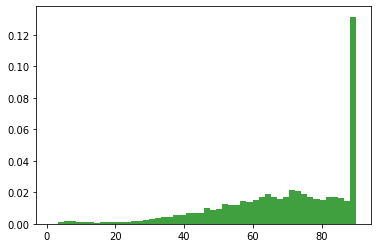

In [35]:
n, bins, patches = plt.hist(df.eGFR.values, 50, density=True, facecolor='g', alpha=0.75)

In [74]:
print(list(df) == list(dfe) == list(dfp))
print(list(outcomes) == list(outcomese))

True
True


In [36]:
df.to_csv("X.csv", index=False)
dfp.to_csv("Xp.csv", index=False)
outcomes.to_csv("y.csv", index=False)
dfe.to_csv("X_ev.csv", index=False)
outcomese.to_csv("y_ev.csv", index=False)

In [37]:
import json

with open('feature_list.json', 'w') as outfile:
    json.dump(feature_dict, outfile, indent=1)
outfile.close()

In [38]:
## create characteristics table
from docx import Document

demos = [x['colname'] for x in feature_dict if x['class']=='demographic']
hist = [x['colname'] for x in feature_dict if x['class']=='history']
phys = [x['colname'] for x in feature_dict if x['class']=='physiology']
oper = [x['colname'] for x in feature_dict if x['class']=='operative']
postop = [x['colname'] for x in feature_dict if x['class']=='postoperative']

partial_colnames = list(ev)

document = Document()
t1_m = document.add_table(rows=1, cols=3)
document.add_page_break()
t1_s = document.add_table(rows=1, cols=4)
document.add_page_break()
t3_s = document.add_table(rows=1, cols=4)

t1_m_hdr_cells = t1_m.rows[0].cells
t1_m_hdr_cells[0].text = 'Variable'
t1_m_hdr_cells[1].text = 'ANZSCTS Subset \nMean (SD) or %'
t1_m_hdr_cells[2].text = 'MIMIC III Subset \nMean (SD) or %'

def table1_main_add(var):
    if var in partial_colnames:
        dfd = [x for x in feature_dict if x['colname']==var]
        if dfd[0]['type']=='number':
            row_cells = t1_m.add_row().cells
            row_cells[0].text = dfd[0]['name']
            mu = np.mean(df[var].dropna().values)
            std = np.std(df[var].dropna().values)
            mu_ev = np.mean(dfe[var].dropna().values)
            std_ev = np.std(dfe[var].dropna().values)
            row_cells[1].text = "{:.2f}".format(mu) + " ({:.2f})".format(std)
            row_cells[2].text = "{:.2f}".format(mu_ev) + " ({:.2f})".format(std_ev)
        elif dfd[0]['type']=='categorical' or dfd[0]['type']=='ordinal':
            row_cells = t1_m.add_row().cells
            row_cells[0].text = dfd[0]['name']
            length = df[var].dropna().values.size
            length_ev = dfe[var].dropna().values.size
            counts = df[var].value_counts()
            counts_ev = dfe[var].value_counts()
            for v in zip(dfd[0]['val_label'], dfd[0]['values']):
                if v[1] != -1:
                    row_cells = t1_m.add_row().cells
                    row_cells[0].text = '    ' + v[0]
                    for i in [(1, counts, length), (2, counts_ev, length_ev)]:
                        try:
                            row_cells[i[0]].text = "{:.2f}".format(i[1][v[1]] / i[2] * 100) + "%"
                        except Exception as e:
                            row_cells[i[0]].text = "0%"
        else:
            row_cells = t1_m.add_row().cells
            row_cells[0].text = dfd[0]['name']
            count = np.sum(df[var].dropna().values == 1) / df[var].dropna().values.size * 100
            count_ev = np.sum(dfe[var].dropna().values) / ev[var].dropna().values.size * 100
            row_cells[1].text = "{:.2f}".format(count) + "%"
            row_cells[2].text = "{:.2f}".format(count_ev) + "%"

for d in demos:
    table1_main_add(d)
                    
for d in hist:
    table1_main_add(d)                

for d in phys:
    table1_main_add(d)                

for d in oper:
    table1_main_add(d)                

for d in postop:
    table1_main_add(d)                


t3_s_hdr_cells = t3_s.rows[0].cells
t3_s_hdr_cells[0].text = 'Variable'
t3_s_hdr_cells[1].text = 'ANZSCTS Subset \nMean (SD) or %'
t3_s_hdr_cells[2].text = 'MIMIC III Subset \nMean (SD) or %'
t3_s_hdr_cells[3].text = 'Missingness % \n(ANZSCTS/MIMIC)'

def table3_supp_add(var):
    dfd = [x for x in feature_dict if x['colname']==var]
    if dfd[0]['type']=='number':
        row_cells = t3_s.add_row().cells
        row_cells[0].text = dfd[0]['name']
        mu = np.mean(df[var].dropna().values)
        std = np.std(df[var].dropna().values)
        missing = np.sum(np.isnan(df[var].values))
        length = df[var].values.size
        row_cells[1].text = "{:.2f}".format(mu) + " ({:.2f})".format(std)
        if var in list(ev):
            mu_ev = np.mean(dfe[var].dropna().values)
            std_ev = np.std(dfe[var].dropna().values)
            missing_ev = np.sum(np.isnan(dfe[var].values))
            length_ev = dfe[var].values.size
            row_cells[2].text = "{:.2f}".format(mu_ev) + " ({:.2f})".format(std_ev)
            row_cells[3].text = "{:.2f}".format(missing/length*100) + "/" +  "{:.2f}".format(missing_ev/length_ev*100)
        else:
            row_cells[3].text = "{:.2f}".format(missing/length*100)
    elif dfd[0]['type']=='categorical' or dfd[0]['type']=='ordinal':
        row_cells = t3_s.add_row().cells
        row_cells[0].text = dfd[0]['name']
        length = data[var].dropna().values.size
        len_m = data[var].values.size
        counts = data[var].value_counts()
        missing = np.sum(np.isnan(data[var].values))
        if var in list(ev):
            length_ev = ev[var].dropna().values.size
            len_m_ev = ev[var].values.size
            counts_ev = ev[var].value_counts()
            missing_ev = np.sum(np.isnan(ev[var].values))
            row_cells[3].text = "{:.2f}".format(missing/len_m*100) + "/" +  "{:.2f}".format(missing_ev/len_m_ev*100)
        else:
            length_ev = -1
            counts_ev = -1
            row_cells[3].text = "{:.2f}".format(missing/len_m*100)
        for v in zip(dfd[0]['val_label'], dfd[0]['values']):
            if v[1] != -1:
                row_cells = t3_s.add_row().cells
                row_cells[0].text = '    ' + v[0]
                for i in [(1, counts, length), (2, counts_ev, length_ev)]:
                    try:
                        row_cells[i[0]].text = "{:.2f}".format(i[1][v[1]] / i[2] * 100) + "%"
                    except Exception as e:
                        print(e)
                        if var in list(ev):
                            row_cells[i[0]].text = "0%"
    else:
        row_cells = t3_s.add_row().cells
        row_cells[0].text = dfd[0]['name']
        count = np.sum(df[var].dropna().values == 1) / df[var].dropna().values.size * 100
        row_cells[1].text = "{:.2f}".format(count) + "%"
        missing = np.sum(np.isnan(df[var].values))
        length = df[var].values.size
        if var in list(ev):
            count_ev = np.sum(dfe[var].dropna().values == 1) / ev[var].dropna().values.size * 100
            length_ev = dfe[var].values.size
            missing_ev = np.sum(np.isnan(dfe[var].values))
            row_cells[2].text = "{:.2f}".format(count_ev) + "%"
            row_cells[3].text = "{:.2f}".format(missing/length*100) + "/" +  "{:.2f}".format(missing_ev/length_ev*100)
        else:
            row_cells[3].text = "{:.2f}".format(missing/length*100)

for d in demos:
    table3_supp_add(d)
                    
for d in hist:
    table3_supp_add(d)                

for d in phys:
    table3_supp_add(d)                

for d in oper:
    table3_supp_add(d)                

for d in postop:
    table3_supp_add(d)

document.save('characteristics.docx')


ModuleNotFoundError: No module named 'docx'

In [41]:


[x for x in feature_dict if x['type']=='categorical']

[{'name': 'Insurance',
  'colname': 'Insur',
  'type': 'categorical',
  'values': [-1, 1, 2, 3, 4, 5, 6],
  'val_label': ['Unknown',
   'Private',
   'DVA',
   'Medicare',
   'Self Insured',
   'Overseas',
   'Other'],
  'units': 'NaN',
  'timing': 0,
  'class': 'demographic'},
 {'name': 'Type of Cerebrovascular Disease',
  'colname': 'CBVD_T',
  'type': 'categorical',
  'values': [-1, 1, 2, 3, 4],
  'val_label': ['Unknown/None',
   'Coma',
   'CVA',
   'RIND/TIA',
   'Carotid Occlusive Disease'],
  'units': 'NaN',
  'timing': 0,
  'class': 'history'},
 {'name': 'Infective Endocarditis',
  'colname': 'IE_T',
  'type': 'categorical',
  'values': [-1, 1, 2],
  'val_label': ['Unknown/None', 'Active', 'Treated'],
  'units': 'NaN',
  'timing': 0,
  'class': 'history'},
 {'name': 'Type of Operation',
  'colname': 'TP',
  'type': 'categorical',
  'values': [-1, 1, 2, 3, 4],
  'val_label': ['Unknown/None',
   'CABG alone',
   'Isolated Valve',
   'CABG+Valve',
   'Other'],
  'units': 'NaN',
  

In [22]:
list(ev)

['AGE',
 'Sex',
 'BMI',
 'Insur',
 'ARRT',
 'SMO_H',
 'HCHOL',
 'HYT',
 'PVD',
 'CHF',
 'TP',
 'PRECR',
 'ICU']

In [102]:
ev.Insur.value_counts()

3    4149
1    2690
6     475
4      29
Name: Insur, dtype: int64

In [63]:
dfe

,AGE,Sex,BMI,Race1,Insur,POP,ARRT,SMO_H,SMO_C,DB_CON,...,PULM,CCT,PERF,PRECR,eGFR,HG,MINHT,ICU,VENT,DRAIN_4
0,47.0,1,30.539240,NaN,1,NaN,0.0,0,NaN,NaN,...,NaN,NaN,NaN,44.210,NaN,NaN,NaN,51.7176,NaN,NaN
1,49.0,0,37.676668,NaN,1,NaN,0.0,0,NaN,NaN,...,NaN,NaN,NaN,70.736,NaN,NaN,NaN,75.2304,NaN,NaN
2,69.0,0,34.295015,NaN,3,NaN,0.0,0,NaN,NaN,...,NaN,NaN,NaN,88.420,NaN,NaN,NaN,31.4904,NaN,NaN
3,37.0,0,45.509113,NaN,6,NaN,0.0,0,NaN,NaN,...,NaN,NaN,NaN,79.578,NaN,NaN,NaN,641.2104,NaN,NaN
4,63.0,0,25.780664,NaN,1,NaN,1.0,0,NaN,NaN,...,NaN,NaN,NaN,300.628,NaN,NaN,NaN,64.9056,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7338,71.0,0,25.151806,NaN,3,NaN,1.0,1,NaN,NaN,...,NaN,NaN,NaN,97.262,NaN,NaN,NaN,53.1888,NaN,NaN
7339,75.0,0,21.162287,NaN,3,NaN,1.0,0,NaN,NaN,...,NaN,NaN,NaN,88.420,NaN,NaN,NaN,30.9720,NaN,NaN
7340,56.0,0,25.133426,NaN,1,NaN,0.0,0,NaN,NaN,...,NaN,NaN,NaN,70.736,NaN,NaN,NaN,77.9256,NaN,NaN
7341,62.0,0,27.045972,NaN,1,NaN,0.0,0,NaN,NaN,...,NaN,NaN,NaN,132.630,NaN,NaN,NaN,54.0648,NaN,NaN


In [120]:
dfp["PatID"] = data.PatID.values
dfp["OpID"] = data.OpID.values
dfp_t = dfp[[
 'PatID',
 'OpID',
 'AGE',
 'Sex',
 'BMI',
 'TP',
 'Insur',
 'ARRT',
 'PVD',
 'HYT',
 'SMO_H',
 'CHF',
 'ICU',
 'HCHOL',
 'PRECR']].dropna()

print(dfp_t.OpID.unique().shape)
print(dfp_t.PatID.unique().shape)

(149988,)
(147317,)


In [112]:
list(ev)

['AGE',
 'Sex',
 'BMI',
 'TP',
 'Insur',
 'ARRT',
 'PVD',
 'HYT',
 'SMO_H',
 'CHF',
 'LD',
 'DB',
 'ICU',
 'MORT30',
 'HCHOL',
 'PRECR']

In [126]:
list(df)[2]

'BMI'